# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [1]:
# import dependencies

import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration

yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990

yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Return Forecasting: Initial Time-Series Plotting
    
### Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures Settle Prices'}, xlabel='Date'>

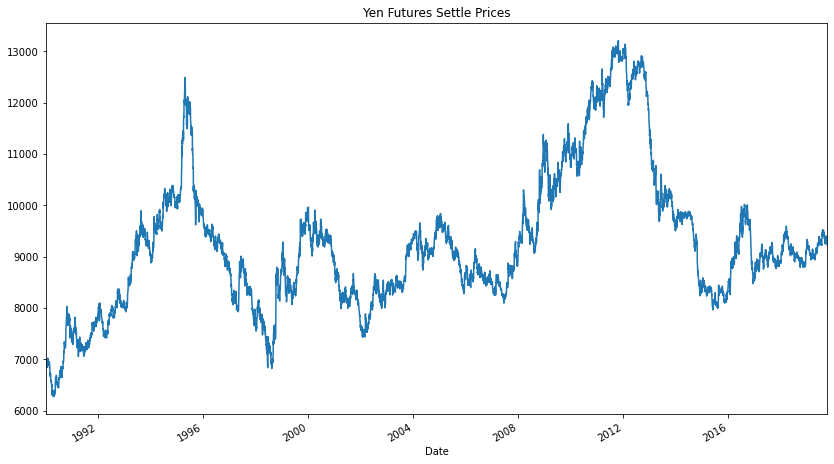

In [4]:
# Plot just the "Settle" column from the dataframe:

settle_plot = yen_futures["Settle"].plot(figsize=(14,8), title = "Yen Futures Settle Prices")
settle_plot

# Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
import statsmodels.api as sm

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:

merge_df = pd.merge(ts_noise, ts_trend, on='Date')
yen_futures2 = yen_futures.iloc[:, 5]
combined_df = pd.merge(yen_futures2, merge_df, on='Date')
combined_df = combined_df.rename(columns = {"Settle_cycle":"Noise", "Settle_trend":"Trend"})
combined_df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle Vs Trend'}, xlabel='Date'>

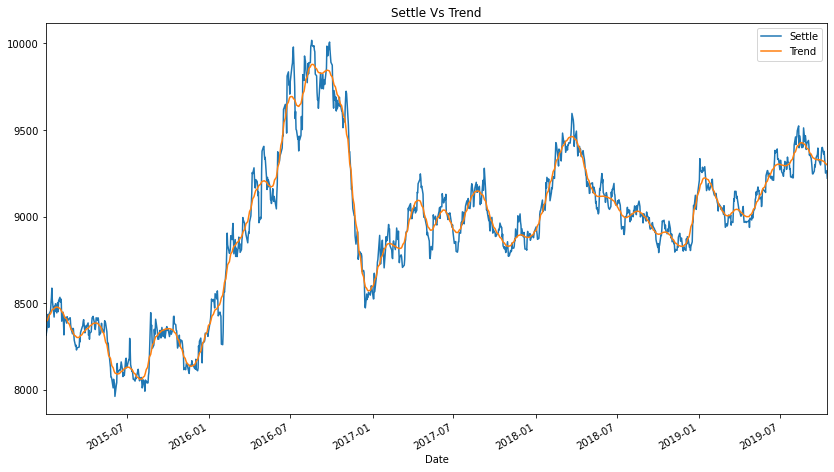

In [9]:
# Plot the Settle Price vs. the Trend for 2015 to the present

combined_df.loc["2015-01-01":].plot(y=["Settle", "Trend"], figsize=(14,8), title="Settle Vs Trend")

<AxesSubplot:xlabel='Date'>

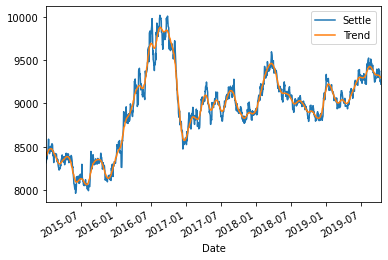

In [13]:
combined_df[["Settle", "Trend"]]["2015-01-01":].plot()

In [ ]:
# Plot the Settle Noise

combined_df["Noise"].plot(figsize = (14,8), title = "Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [ ]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))

model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results

result = model.fit()
result.summary()

In [ ]:
# Plot the 5 Day Returns Forecast

forecast_df = pd.DataFrame(result.forecast(steps=5)[0]).plot(title="Return Forecast", figsize = (14,7))
forecast_df

Based on the P values >.05, this is not a good fit for the model.



# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))

model = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

# Fit the model

results = model.fit()

In [ ]:
# Output model summary results:

results.summary()

In [ ]:
# Plot the 5 Day Price Forecast

arima_forecast = pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast", figsize =(14,7))
arima_forecast

Again, it looks like the P values are not less than .05, so based on that this would not be a good fit. The Japanese Yen appears to be moving up based on this forecast.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [ ]:
from arch import arch_model

# Estimate a GARCH model:

model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model

res = model.fit(disp="off")
res.summary()

In [ ]:
# Find the last day of the dataset

last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility

forecast_horizon = 5

# Start the forecast using the last_day calculated above

forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [ ]:
# Annualize the forecast

intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot

final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast

garch_forecast = final.plot(title = "5 Day Forecast of Volatility", figsize=(14,8))

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

**Answer**: Based on the models fit not being P<.05, I would not trust these evaluations. However, assuming these models were accurate, I suppose the price is set to increase, but so too is the volatility. If I were an aggressive trader, this may present some opportunity, but I'd put my money elsewhere. 